In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import scipy
from tqdm import tqdm
import pdb

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


class RFModel(nn.Module):
    def __init__(self, input_dim, n_features, K,  W = None, a= None , activation='relu', finetuned_model= None,\
                  retain_model = None, loss_type='GA',eval_loss = 'l2',\
                    eval_retain_dataset = None,eval_forget_dataset = None,beta = None,eval_steps = 1,add_constant = False,**kwargs):
     
        super(RFModel, self).__init__()
        self.input_dim = input_dim
        self.n_features = n_features
        self.K = K ## number of classes
        assert input_dim > 0 and n_features > 0

        if W is None:
            self.W = torch.tensor(torch.randn(input_dim, n_features)/input_dim**0.5,dtype = torch.float64,requires_grad = False)  # Random weight matrix W
        else:
            self.W = W.clone().detach().to(torch.float64)
        if a is None:
            if add_constant:
                self.a = torch.zeros((n_features+1, K-1),dtype = torch.float64,requires_grad = True)
            else:
                self.a = torch.zeros((n_features, K-1),dtype = torch.float64,requires_grad = True)

        else:
            self.a = a.clone().detach().to(torch.float64).requires_grad_(True)
        
        if activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'sigmoid':
            self.activation = nn.Sigmoid()
        else:
            raise ValueError("Unsupported activation function.")
        
        self.finetuned_model = finetuned_model      
        self.retain_model = retain_model

       

        if not (eval_retain_dataset is None or eval_forget_dataset is None):
            self.X_eval_r_dataset, self.y_eval_r_dataset = eval_retain_dataset
            self.X_eval_f_dataset, self.y_eval_f_dataset = eval_forget_dataset

        self.loss_type = loss_type
        self.eval_loss = eval_loss
        self.beta = beta  ## parameter for the dpo/npo loss
        self.eval_steps = eval_steps
        self.add_constant = add_constant
        
       
       

    def pretrained_model(self, X, y):
        """ Train a random feature model """
        
        Z = self.activation(X @ self.W.T)
        
        if self.add_constant:
            Z = torch.hstack([Z, torch.ones(Z.shape[0],1,dtype = torch.float64)])  ## add a constant term

        y_onehot = F.one_hot(y.view(-1), num_classes=self.K).to(torch.float64)


       

        record_loss = []

        v = self.a.clone().detach().requires_grad_(True)
       
        num_iter = 20000
        for ii in range(num_iter):
            
            y_onehot = F.one_hot(y.view(-1), num_classes = self.K).to(torch.float64)
            if self.add_constant:
                log_logits = F.log_softmax(Z @ torch.hstack([v,torch.zeros(self.n_features+1,1,dtype = torch.float64)]),dim = -1)

            else:   
                log_logits = F.log_softmax(Z @ torch.hstack([v,torch.zeros(self.n_features,1,dtype = torch.float64)]),dim = -1)
            
            assert y_onehot.shape == log_logits.shape
            loss = -torch.mean(torch.sum(y_onehot*log_logits,dim=-1))
            loss.backward()
            record_loss.append(loss.item())
            with torch.no_grad():
                if ii == 0:
                    print(f'grad_{torch.norm(v.grad)}_loss_{loss.item()}_iter_{ii}_initial')
                if ii == num_iter-1:
                    print(f'grad_{torch.norm(v.grad)}_loss_{loss.item()}_iter_{ii}')
                    if torch.norm(v.grad) > 1e-3:
                        print('not fully converged_grad is:',torch.norm(v.grad))
                    if torch.norm(v.grad) >1e-2:
                        print('not fully converged_grad is:',torch.norm(v.grad))
                        raise ValueError("Not fully converged")
                        
                v -= .05*v.grad   ## default learning rate is 0.05,20000steps (for overlap distribution)
                v.grad.zero_()
            
            
        # plt.plot(record_loss)
        # plt.show()
                
        

                
        

       

        self.a = v.clone().detach().requires_grad_(True)
        
        
       
        return v.clone().detach().requires_grad_(False)
        
       
    
    def forward(self, X,log_target = False):
        """
        Forward pass through the model.
        """

        


        Z = self.activation(X @ self.W.T)
        if self.add_constant:
            Z = torch.hstack([Z, torch.ones(Z.shape[0],1,dtype = torch.float64)])  ## add a constant term
        if self.add_constant:
            a_combined = torch.hstack([self.a, torch.zeros(self.n_features+1, 1, dtype=torch.float64)])
        else:
            a_combined = torch.hstack([self.a, torch.zeros(self.n_features, 1, dtype=torch.float64)])

        if log_target:
            predictions = F.log_softmax(Z @ a_combined, dim = -1)
        else:
            predictions = F.softmax(Z @ a_combined,dim = -1)
            assert predictions.shape == (X.shape[0],self.K)
            
        return predictions

    def train_model(self, data, learning_rate=0.01, steps=100,evaluate = True):


        """
        Trains the model using gradient descent.
        """

        ##start with the evaluation
        

        (X_r, y_r), (X_f, y_f), y_idk = data

        record_all = {}
        for key in ['forget_quality', 'retain_quality', 'forget_diff', 'retain_diff',"a_dist"]:
            record_all[key] = []

        ## change the label to one-hot encoding
        y_r = F.one_hot(y_r.view(-1), num_classes = self.K).to(torch.float64)
        y_f = F.one_hot(y_f.view(-1), num_classes = self.K).to(torch.float64)
        y_idk = F.one_hot(y_idk.view(-1), num_classes = self.K).to(torch.float64)

        assert y_r.shape == (X_r.shape[0],self.K)
        assert y_f.shape == (X_f.shape[0],self.K)

        




        for step_curr in tqdm(range(steps)):



            ## start with the evaluation
            if evaluate and  step_curr % self.eval_steps == 0:
                
                eval_dict = self.evaluation()
                for key, value in eval_dict.items():
                    record_all[key].append(value)



                ##test only
                self.test_eval_prob(X_f,y_f, data_type = 'forget')
                #self.test_eval_prob(X_r, y_r,data_type = 'retain')

         
            


            if self.a.grad is not None:
                self.a.grad.zero_()
            
            ## compute the loss
            if self.loss_type == 'jsd_loss':  # Jensen-Shannon Divergence Loss
                # Predictions for forget dataset
                prediction_f = self.forward(X_f, log_target=False)
                with torch.no_grad():
                    prediction_f_finetuned = self.finetuned_model.forward(X_f, log_target=False)
                
                # JSD between current and fine-tuned predictions for forget dataset
                m = 0.5 * (prediction_f + prediction_f_finetuned)
                kl_p_m = F.kl_div(m.log(), prediction_f, reduction='batchmean')
                kl_q_m = F.kl_div(m.log(), prediction_f_finetuned, reduction='batchmean')
                loss_f = 0.5 * (kl_p_m + kl_q_m)
                
                # print(loss_f)
                # Predictions for retain dataset
                prediction_r = self.forward(X_r, log_target=True)
                loss_r = -torch.mean(torch.sum(y_r * prediction_r, dim=-1))

                # Total loss
                loss = loss_f + loss_r

            elif self.loss_type == 'alpha_loss':
                prediction_r = self.forward(X_r, log_target=True)
                with torch.no_grad():
                    prediction_r_finetuned = self.finetuned_model.forward(X_r, log_target=False)

                m = 0.5 * (prediction_r + prediction_r_finetuned)
                kl_p_m = F.kl_div(m.log(), prediction_r, reduction='batchmean')
                kl_q_m = F.kl_div(m.log(), prediction_r_finetuned, reduction='batchmean')
                loss_r = 0.5 * (kl_p_m + kl_q_m)

                prediction_f = self.forward(X_f, log_target=False)
                with torch.no_grad():
                    prediction_f_finetuned = self.finetuned_model.forward(X_f, log_target=False)
                alpha = 0.2
                
                prod = torch.mul( prediction_f**((1+alpha)/2),prediction_f_finetuned**((1-alpha)/2))
                # if step_curr == 1:
                #     var3 = prod
                # print(prod)
                mynum = torch.sum(prod)
                # var4 = mynum
                # print(mynum)
                loss_f = 1-mynum
                # print("mynum",mynum)
                loss_f = -(4/(1-alpha**2))*loss_f
                # print(loss_f)
                loss = loss_f+loss_r

            elif self.loss_type == 'grad_ascent':
                
                prediction = self.forward(X_f,log_target=True) ## log prediction
                assert prediction.shape == (X_f.shape[0],self.K)
                #if torch.isnan(prediction).any():
                    #pdb.set_trace()
                #loss = torch.mean(y_f*torch.log(prediction)+ (1-y_f)*torch.log(1-prediction))
                loss = torch.mean(torch.sum(y_f*prediction,dim=-1))
            elif self.loss_type == 'grad_descent':  ## for sanity check
                prediction = self.forward(X_r,log_target=True) ## log prediction
                
                loss = -torch.mean(torch.sum(y_r*prediction,dim=-1))
            elif self.loss_type == 'grad_diff':
                prediction_f = self.forward(X_f,log_target=True)
                prediction_r = self.forward(X_r,log_target=True)

                loss_f = torch.mean(torch.sum(y_f*prediction_f,dim=-1))
                loss_r = -torch.mean(torch.sum(y_r*prediction_r,dim=-1))
    
                loss = loss_f + loss_r
            elif self.loss_type == 'grad_diff_KL_forget':
                prediction_f = self.forward(X_f,log_target=True)
                prediction_r = self.forward(X_r,log_target=True)
                with torch.no_grad():   
                    prediction_f_finetuned = self.finetuned_model.forward(X_f,log_target=True)
                
                
                loss_f = torch.mean(torch.sum(y_f*prediction_f,dim=-1))
                loss_r = -torch.mean(torch.sum(y_r*prediction_r,dim=-1))

                kl_forget = F.kl_div(prediction_f,prediction_f_finetuned, reduction = 'batchmean',log_target = True)  ##this computes KL(finetunwed||current)
                ## This is equivalent to the following
                #my_kl_forget = torch.mean(torch.sum(torch.exp(prediction_f_finetuned)*(prediction_f_finetuned-prediction_f),dim = -1))
               
                
    
                loss = loss_f + loss_r + 2*kl_forget
            elif self.loss_type == 'KL':
                
                prediction_f = self.forward(X_f,log_target=True)
                prediction_r = self.forward(X_r,log_target=True) 
                
                with torch.no_grad():   
                    prediction_r_finetuned = self.finetuned_model.forward(X_r,log_target=True)

                
          
                

                
                loss_f = torch.mean(torch.sum(y_f*prediction_f,dim=-1))

                kl_retain = F.kl_div(prediction_r, prediction_r_finetuned, reduction = 'batchmean',log_target = True)  ##this computes KL(finetunwed||current)
                
                
                loss = loss_f + kl_retain

            elif self.loss_type == 'idk':

                prediction_f = self.forward(X_f,log_target=True)
                prediction_r = self.forward(X_r,log_target=True)

                loss_r = -torch.mean(torch.sum(y_r*prediction_r,dim=-1))


                
                loss = - torch.mean(torch.sum(y_idk*prediction_f,dim=-1))

                loss = loss + loss_r



            elif self.loss_type in ['non_paired_dpo','non_paired_dpo_KL','non_paired_dpo_GDiff']:

                prediction_f = self.forward(X_f,log_target=True)
                outputs_f = torch.sum(prediction_f*y_f,dim=-1).view(-1,1)

                with torch.no_grad():
                    prediction_f_finetuned = self.finetuned_model.forward(X_f,log_target=True)

                    outputs_f_finetuned = torch.sum(prediction_f_finetuned*y_f,dim=-1).view(-1,1) 
                    assert outputs_f_finetuned.shape == (X_f.shape[0],1)

                
                neg_log_ratio = outputs_f_finetuned - outputs_f
                loss = -F.logsigmoid(self.beta*neg_log_ratio).mean()*2/self.beta


            

        

                if self.loss_type == 'non_paired_dpo_KL':
                    prediction_r = self.forward(X_r,log_target=True) 
                    with torch.no_grad():   
                        prediction_r_finetuned = self.finetuned_model.forward(X_r,log_target=True)

                    
                    kl_retain = F.kl_div(prediction_r, prediction_r_finetuned, reduction = 'batchmean',log_target = True)  ##this computes KL(finetunwed||current)
                    
                    loss = loss + kl_retain
                
                if self.loss_type == 'non_paired_dpo_GDiff':
                    prediction_r = self.forward(X_r,log_target=True)

                    loss_r = -torch.mean(torch.sum(y_r*prediction_r,dim=-1))
                    loss = loss + loss_r

        

            elif self.loss_type in ['dpo','dpo_KL','dpo_GDiff']:
                prediction_f = self.forward(X_f,log_target=True)
                with torch.no_grad():
                    prediction_f_finetuned = self.finetuned_model.forward(X_f,log_target=True)

                    outputs_f_finetuned = torch.sum(prediction_f_finetuned*y_f,dim=-1).view(-1,1)
                    outputs_f_finetuned_idk = torch.sum(prediction_f_finetuned*y_idk,dim=-1).view(-1,1)



                outputs_f = torch.sum(prediction_f*y_f,dim=-1).view(-1,1)
                outputs_f_idk = torch.sum(prediction_f*y_idk,dim=-1).view(-1,1)


                

                log_ratio = (outputs_f_idk - outputs_f_finetuned_idk)- (outputs_f - outputs_f_finetuned)
                loss = -F.logsigmoid(self.beta*log_ratio).mean()*2/self.beta
                if self.loss_type == 'dpo_KL':
                    prediction_r = self.forward(X_r,log_target=True) 
                    with torch.no_grad():   
                        prediction_r_finetuned = self.finetuned_model.forward(X_r,log_target=True)


                    kl_retain = F.kl_div(prediction_r, prediction_r_finetuned, reduction = 'batchmean',log_target = True)  ##this computes KL(finetunwed||current)

                    
                    
                    loss = loss + kl_retain
                if self.loss_type == 'dpo_GDiff':
                    prediction_r = self.forward(X_r,log_target=True)

                    loss_r = -torch.mean(torch.sum(y_r*prediction_r,dim=-1))
                   
                    loss = loss + loss_r

            elif self.loss_type in ['kto']:
                prediction_f = self.forward(X_f,log_target= True)
                outputs_f = torch.sum(prediction_f*y_f,dim=-1).view(-1,1)

                with torch.no_grad():
                    prediction_f_finetuned = self.finetuned_model.forward(X_f,log_target=True)
                    outputs_f_finetuned = torch.sum(prediction_f_finetuned*y_f,dim=-1).view(-1,1)

                    

                
                neg_log_ratio = outputs_f_finetuned-outputs_f

                with torch.no_grad():
                    prediction_f2 = self.forward(X_f,log_target=True)
                    kl_divergence = F.kl_div(prediction_f_finetuned, prediction_f2, reduction = 'batchmean',log_target = True)


                all_log_ratio = kl_divergence + neg_log_ratio
                assert all_log_ratio.shape == neg_log_ratio.shape
                loss = -F.logsigmoid(self.beta*all_log_ratio).mean()*2/self.beta
                


                
                


            
            # Compute gradients
            loss.backward()
        
            with torch.no_grad():  # Ensure gradients are not tracked during the update

              
                
                self.a -= learning_rate * self.a.grad
                

            
        
        if evaluate:
            #print(self.a- self.retain_model.a)
            return record_all
        
        
        
                

               
                
    
    def evaluation(self):
        if self.eval_loss == 'KL':
            eval_logarithm = True
        else:
            eval_logarithm = False
        with torch.no_grad():
            
            #pdb.set_trace()

            p_hat_r = self.forward(self.X_eval_r_dataset,log_target=eval_logarithm)  ## note that this is NOT logprobability
            p_hat_r_retain = self.retain_model.forward(self.X_eval_r_dataset,log_target=eval_logarithm)
            p_hat_r_finetuned = self.finetuned_model.forward(self.X_eval_r_dataset,log_target=eval_logarithm)
           
            p_hat_f = self.forward(self.X_eval_f_dataset,log_target=eval_logarithm)
            p_hat_f_retain = self.retain_model.forward(self.X_eval_f_dataset,log_target=eval_logarithm)    
            p_hat_f_finetuned = self.finetuned_model.forward(self.X_eval_f_dataset,log_target=eval_logarithm)
        
   

        eval_dict = {}  ## dictionary to store evaluation results
        eval_dict['forget_quality'] = self.eval_fun(p_hat_f, p_hat_f_retain,self.eval_loss) ## loss between current and retain model on forget distribution
        eval_dict['retain_quality'] = self.eval_fun(p_hat_r, p_hat_r_retain,self.eval_loss) ## loss between current and retain model on retain distribution
        eval_dict['forget_diff'] = self.eval_fun(p_hat_f, p_hat_f_finetuned,self.eval_loss) ## loss divergence between current and finetuned model on forget distribution
        eval_dict['retain_diff'] = self.eval_fun(p_hat_r, p_hat_r_finetuned,self.eval_loss) ## loss divergence between current and finetuned model on retain distribution
        with torch.no_grad():
            eval_dict['a_dist'] = torch.norm(self.a- self.retain_model.a)#/torch.norm(self.retain_model.a)
        
        return eval_dict
    
    def eval_fun(self,p,q,loss_type='KL'): ## p is prediction

        p,q = p.clone().detach(), q.clone().detach()
        
        if loss_type == 'KL':   ##compute KL(q||p); this is the standard KL divergence (F.kl_div) where q is the true distribution and p is the estimated distribution
           
            return F.kl_div(p,q, reduction = 'batchmean',log_target = True).numpy()
        


        
        p,q = p.numpy(), q.numpy()
        
       
        if loss_type == 'l2':
            return np.mean(np.sum((p-q)**2,axis = -1)**0.5)
        elif loss_type == 'l1':
            return np.mean(np.sum(np.abs(p-q),axis = -1))
        elif loss_type == 'KS': ## compute the KS statistic (the maximum difference between the two cdfs)
            if self.K > 2:
                raise ValueError("KS statistic is only defined for 2 classes.")
            return ks_distance(p,q) ## only works for 2-d
    
    def test_eval_prob(self,X,y, data_type = 'retain'):

        if self.beta is None:
            return
        
        return 
    
        X = X.clone().detach()
        with torch.no_grad():
            p_retain = self.retain_model.forward(X)
            p_finetuned = self.finetuned_model.forward(X)
            p = self.forward(X)

            
            
            curr_ratio = p**self.beta/(p_finetuned**self.beta+p**self.beta)*2/self.beta
            retain_ratio = p_retain**self.beta/(p_finetuned**self.beta+p_retain**self.beta)*2/self.beta

            

            # curr_ratio =p/(p_finetuned+p)*2
            # retain_ratio = p_retain/(p_finetuned+p_retain)*2

            assert curr_ratio.shape == (X.shape[0],self.K)
            curr_ratio = torch.sum(curr_ratio*y,dim = -1)  ## y is one-hot matrix
            retain_ratio = torch.sum(y* retain_ratio,dim = -1)
            
         
            curr_ratio_mean = torch.mean(curr_ratio,dim = 0)
            curr_ratio_std = torch.std(curr_ratio,dim = 0)
            retain_ratio_mean = torch.mean(retain_ratio,dim = 0)
            retain_ratio_std = torch.std(retain_ratio,dim = 0)

            print(f"current:{curr_ratio_mean}_std_{curr_ratio_std}_retain:{retain_ratio_mean}_std_{retain_ratio_std}_{data_type}")
            

    

def empirical_cdf(sample):
       
    n = sample.shape[0]
    assert n>1
    sorted_sample = np.sort(sample)
    cdf_values = np.arange(1, n + 1) / n
    return sorted_sample, cdf_values

def ks_distance(sample1, sample2):
       
    # Compute empirical CDFs
    sorted_sample1, cdf1 = empirical_cdf(sample1)
    sorted_sample2, cdf2 = empirical_cdf(sample2)
    
    # Combine the samples and sort
    all_samples = np.concatenate([sorted_sample1, sorted_sample2])
    unique_samples = np.unique(all_samples)
    
    # Compute CDFs at combined points
    cdf1_at_combined = np.searchsorted(sorted_sample1, unique_samples, side='right') / sample1.size
    cdf2_at_combined = np.searchsorted(sorted_sample2, unique_samples, side='right') / sample2.size
    
    # Compute the KS statistic
    ks_statistic = np.max(np.abs(cdf1_at_combined - cdf2_at_combined))
        
    return ks_statistic

In [ ]:
# if self.loss_type == 'jsd_loss':  # Jensen-Shannon Divergence Loss
            #     # Predictions for forget dataset
            #     prediction_f = self.forward(X_f, log_target=False)
            #     with torch.no_grad():
            #         prediction_f_finetuned = self.finetuned_model.forward(X_f, log_target=False)
                
            #     # JSD between current and fine-tuned predictions for forget dataset
            #     m = 0.5 * (prediction_f + prediction_f_finetuned)
            #     kl_p_m = F.kl_div(m.log(), prediction_f, reduction='batchmean')
            #     kl_q_m = F.kl_div(m.log(), prediction_f_finetuned, reduction='batchmean')
            #     loss_f = 0.5 * (kl_p_m + kl_q_m)
                
            #     # print(loss_f)
            #     # Predictions for retain dataset
            #     prediction_r = self.forward(X_r, log_target=True)
            #     loss_r = -torch.mean(torch.sum(y_r * prediction_r, dim=-1))

            #     # Total loss
            #     loss = loss_f + loss_r

        #    elif self.loss_type == 'alpha_loss':
        #         prediction_r = self.forward(X_r, log_target=True)
        #         with torch.no_grad():
        #             prediction_r_finetuned = self.finetuned_model.forward(X_r, log_target=False)

        #         m = 0.5 * (prediction_r + prediction_r_finetuned)
        #         kl_p_m = F.kl_div(m.log(), prediction_r, reduction='batchmean')
        #         kl_q_m = F.kl_div(m.log(), prediction_r_finetuned, reduction='batchmean')
        #         loss_r = 0.5 * (kl_p_m + kl_q_m)

        #         prediction_f = self.forward(X_f, log_target=False)
        #         with torch.no_grad():
        #             prediction_f_finetuned = self.finetuned_model.forward(X_f, log_target=False)
        #         alpha = 0.2
                
        #         prod = torch.mul( prediction_f**((1+alpha)/2),prediction_f_finetuned**((1-alpha)/2))
        #         # if step_curr == 1:
        #         #     var3 = prod
        #         # print(prod)
        #         mynum = torch.sum(prod)
        #         # var4 = mynum
        #         # print(mynum)
        #         loss_f = 1-mynum
        #         # print("mynum",mynum)
        #         loss_f = -(4/(1-alpha**2))*loss_f
        #         # print(loss_f)
        #         loss = loss_f+loss_r


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from scipy.stats import entropy
import scipy
from tqdm import tqdm
import pdb

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F



class MyDist():  ## logistic distribution
    def __init__(self,K,theta_list,mu_list, sigma2_list,prob_list,intercept_list,translation_list = None):
        self.num_modes = len(mu_list)
        self.mu_list = [ mu.clone().detach() for mu in mu_list]  ## 1-d tensor
        if translation_list is not None:
            self.translation_list = [translation.clone().detach() for translation in translation_list]
        else:
            self.translation_list = [mu.clone().detach() for mu in mu_list] ## 1-d tensor, by default, the translations are the same as mu
        self.d = len(mu_list[0])
        self.sigma2_list = [sigma2.clone().detach() for sigma2 in sigma2_list]  ## 2-d tensor
        self.K = K
        self.theta_list = [theta.clone().detach().view(-1,K) for theta in theta_list]  ## 2-d tensor
        self.prob_list = prob_list
        self.intercept_list = [intercept.clone().detach().view(1,K) for intercept in intercept_list] ## 2-d tensor
        
        assert len(prob_list) == self.num_modes
       
    def generate_data(self,n):
        ##get n samples from prob_list
        mode_id = torch.multinomial(torch.tensor(self.prob_list), num_samples = n, replacement = True)
        assert mode_id.size() == (n,)
        X = torch.zeros(n,self.d,dtype = torch.float64)
        y = torch.zeros(n,1,dtype = torch.int64)
        
        for i in range(n):

            mode = mode_id[i]
            X[i,:] = torch.distributions.MultivariateNormal(self.mu_list[mode], self.sigma2_list[mode]).sample()
            logits = F.softmax((X[i,:]-self.translation_list[mode]).view(1,-1)@self.theta_list[mode]+self.intercept_list[mode], dim=-1,dtype = torch.float64)  ## 1 by K
            y[i,0] = torch.multinomial(logits,num_samples = 1)  ## 1 by 1
            

     
        # X = torch.distributions.MultivariateNormal(self.mu, self.sigma2).sample((n,))
        # ##generate from K-dim discrete distribution
        # logits = F.softmax(X@self.theta, dim=-1,dtype = torch.float64)  ## n by K
    
        # y = torch.multinomial(logits,num_samples = 1)  ## n by 1
        
        
        return X, y
    def generate_label(self,X):  ## not working for now

        logits = F.softmax(X@self.theta, dim=-1,dtype = torch.float64)  ## n by K
        y = torch.multinomial(logits,num_samples = 1)  ## n by 1
        

           
        return  y


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from scipy.stats import entropy
import scipy
from tqdm import tqdm
import pdb

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pickle
import os


# from mymodel import RFModel
# from dist import MyDist









# Parameters for data generation
K = 2 # number of classes
d = 16  # dimension of the data
N =128 ## number of neurons
sigma_r, sigma_f = 1,1 # standard deviation     
i_value_r, i_value_f = 1,1 ## intercept value  ##logit is N(i,c^2sigma^2)
alpha = 1        
c_theta = 1 ## scaling of theta (default 1)


rep = 1 # number of repetitions


mean_shift_r, mean_shift_f1,mean_shift_f2,mean_shift_f3 = -1*alpha*torch.ones(d,dtype = torch.float64), 1*alpha* torch.ones(d,dtype = torch.float64),\
            alpha*torch.zeros(d,dtype = torch.float64), alpha*torch.zeros(d,dtype = torch.float64) # mean shift for retain and forget dataset

            
intercept_r, intercept_f1,intercept_f2,intercept_f3 = torch.zeros(K,dtype = torch.float64), torch.zeros(K,dtype = torch.float64),\
            torch.zeros(K,dtype = torch.float64), torch.zeros(K,dtype = torch.float64) # intercept for retain and forget dataset


intercept_r[0] = i_value_r
intercept_f1[1] = i_value_f
intercept_f2[1] = i_value_f
intercept_f3[1] = i_value_f






n_r, n_f, n_eval_r, n_eval_f = 1000, 200, 1000, 1000  # number of samples



theta_r = torch.zeros((d,K),dtype = torch.float64)  # parameters for retain dataset
theta_r[:,0] = c_theta*torch.ones(d,dtype = torch.float64)/d**0.5


theta_f1 = torch.zeros((d,K),dtype = torch.float64)  # parameters for forget dataset
theta_f1[:,1]=c_theta*torch.ones(d,dtype = torch.float64)/d**0.5


theta_f2 = torch.zeros((d,K),dtype = torch.float64)  # parameters for forget dataset
theta_f2[:,1]=c_theta*torch.ones(d,dtype = torch.float64)/d**0.5


theta_f3 = torch.zeros((d,K),dtype = torch.float64)  # parameters for forget dataset
theta_f3[:,1]=c_theta*torch.ones(d,dtype = torch.float64)/d**0.5



retain_dist = MyDist(K = K, theta_list = [theta_r], mu_list = [mean_shift_r], sigma2_list = [sigma_r**2*torch.eye(d,dtype = torch.float64)],\
                     prob_list = [1.],intercept_list=[intercept_r])   ## torch.multivariate.normal uses covariance matrix
forget_dist = MyDist(K = K, theta_list = [theta_f1,theta_f2,theta_f3], mu_list = [mean_shift_f1,mean_shift_f2,mean_shift_f3],\
                      sigma2_list = [sigma_f**2*torch.eye(d,dtype = torch.float64) for ii in range(3)],prob_list = [1.,0.,0],\
                        intercept_list=[intercept_f1,intercept_f2,intercept_f3])





seed_list = [1000,2000,3000,4000,5000]









for seed in seed_list:

    torch.manual_seed(seed)

    W = torch.randn(N,d,dtype = torch.float64)/d**0.5  ## weights for the random features
    #torch.seed()


    #torch.manual_seed(1001)

    ## generate the training dataset
    #torch.manual_seed(1000)
    retain_dataset = retain_dist.generate_data(n_r)
    forget_dataset = forget_dist.generate_data(n_f)





    retain_num = [torch.sum(retain_dataset[1] == ii) for ii in range(K)]
    forget_num = [torch.sum(forget_dataset[1] == ii) for ii in range(K)]
    print(f'retain_num:{retain_num}_forget_num:{forget_num}')




    #y_idk = retain_dist.generate_label(forget_dataset[0])  ##generate idk data
    y_idk = torch.multinomial(F.softmax( torch.zeros((n_f,K),dtype = torch.float64),dtype = torch.float64,dim = -1), num_samples = 1)    ##generate idk data
    assert y_idk.size() == (n_f,1)
    #torch.seed()



    combined_dataset = torch.vstack([retain_dataset[0], forget_dataset[0]]),torch.vstack([retain_dataset[1], forget_dataset[1]])

    ## generate the evaluation dataset



    eval_retain_dataset = retain_dist.generate_data(n_eval_r)
    eval_forget_dataset = forget_dist.generate_data(n_eval_f)









    retain_model = RFModel(input_dim = d, K= K, n_features = N, W = W, a = None, activation = 'relu',add_constant = False)
    finetuned_model = RFModel(input_dim = d, K = K, n_features = N, W = W, a = None, activation = 'relu',add_constant=False,eval_retain_dataset = eval_retain_dataset, eval_forget_dataset = eval_forget_dataset)
                                    


    retain_model.pretrained_model(retain_dataset[0], retain_dataset[1])
    finetuned_model.pretrained_model(combined_dataset[0], combined_dataset[1])




    ## create a subfolder in record file to store the results
    os.makedirs(f'record/record_d{d}_N{N}_K_{K}_nf{n_f}_nr_{n_r}_alpha_{alpha}', exist_ok=True)
    with open(f'record/record_d{d}_N{N}_K_{K}_nf{n_f}_nr_{n_r}_alpha_{alpha}/finetuned_seed_{seed}.pkl', 'wb') as file:
        pickle.dump([(retain_model, finetuned_model),(retain_dataset,forget_dataset,y_idk),\
                    seed,(alpha,sigma_r,sigma_f,c_theta,i_value_r,i_value_f,retain_dist,forget_dist)], file)
        

retain_num:[tensor(688), tensor(312)]_forget_num:[tensor(55), tensor(145)]
grad_1.2980700457018794_loss_0.6931471805599453_iter_0_initial
grad_0.0019959825286956306_loss_0.5220154460645203_iter_19999
not fully converged_grad is: tensor(0.0020, dtype=torch.float64)
grad_1.077560375700476_loss_0.6931471805599453_iter_0_initial
grad_0.001483407280916131_loss_0.5300116677074529_iter_19999
not fully converged_grad is: tensor(0.0015, dtype=torch.float64)
retain_num:[tensor(721), tensor(279)]_forget_num:[tensor(55), tensor(145)]
grad_1.737861491900948_loss_0.6931471805599453_iter_0_initial
grad_0.0020449337423884325_loss_0.499319688378838_iter_19999
not fully converged_grad is: tensor(0.0020, dtype=torch.float64)
grad_1.4260595326403882_loss_0.6931471805599453_iter_0_initial
grad_0.0012509014479199917_loss_0.5096252572130993_iter_19999
not fully converged_grad is: tensor(0.0013, dtype=torch.float64)
retain_num:[tensor(724), tensor(276)]_forget_num:[tensor(56), tensor(144)]
grad_1.685818016062

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from scipy.stats import entropy
import scipy
from tqdm import tqdm
import pdb

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pickle
import os

# from mymodel import RFModel




##parameters

K = 2           ## number of classes
d = 16          ## dimension of the input
N = 128         ## number of random features
n_r = 1000      ## number of retain samples
n_f = 200       ## number of forget samples
alpha = 1      ## the value of the gap


run_id = 1      ## the id of the run
seed_list = [1000,2000,3000,4000,5000]  ## the list of seeds

global_steps  = 2000  ## number of steps for training
eval_steps = 25    ## number of steps between evaluations


# Define a list of configurations
configurations = [

    ('GA', {'loss_type': 'grad_ascent','learning_rate': 5e-4}),
    ('KL', {'loss_type': 'KL','learning_rate': 2e-4}),
    # ('JSD', {'loss_type': 'jsd_loss','learning_rate': 2e-4}),
    # ('alpha-Divergence', {'loss_type': 'alpha_loss','learning_rate': 2e-4}),
    # ('Log-alpha-Divergence', {'loss_type': 'log_alpha_loss','learning_rate': 2e-4}),
    ('GDiff', {'loss_type': 'grad_diff','learning_rate': 2e-4}),
    ('idk', {'loss_type': 'idk','learning_rate': 1e-4}),


    ('NPO', {'loss_type': 'non_paired_dpo','beta': 1, 'learning_rate': 5e-4}),
    # ('NPO_KL', {'loss_type': 'non_paired_dpo_KL','beta': .1,'learning_rate': 2e-4}),
    ('NPO_GDiff', {'loss_type': 'non_paired_dpo_GDiff', 'beta': .1,'learning_rate': 2e-4}),

    # ('dpo', {'loss_type': 'dpo','beta': .1, 'learning_rate': 1e-3}),
    # ('dpo_KL', {'loss_type': 'dpo_KL','beta': .1,'learning_rate': 1e-3}),
    ('dpo_GDiff', {'loss_type': 'dpo_GDiff', 'beta': 0.1,'learning_rate': 1e-3}),


    # ('GDiff_KL', {'loss_type': 'grad_diff_KL_forget','learning_rate': 5e-4}),
    # ('GD', {'loss_type': 'grad_descent','learning_rate': 5e-4}),

    # ('testa', {'loss_type': 'non_paired_dpo', 'beta': 0.1,'learning_rate': 5e-4}),
    # ('testb', {'loss_type':'non_paired_dpo', 'beta': .5,'learning_rate': 1e-3}),
    # ('testc', {'loss_type': 'non_paired_dpo', 'beta': 10.,'learning_rate': 5e-3}),


    # ('NPOa', {'loss_type': 'non_paired_dpo','beta': .01, 'learning_rate': 5e-4}),
    # ('NPOb', {'loss_type': 'non_paired_dpo','beta': .1,'learning_rate': 5e-4}),
    # ('NPOc', {'loss_type': 'non_paired_dpo', 'beta': .2,'learning_rate': 5e-4}),
    # ('NPOd', {'loss_type': 'non_paired_dpo', 'beta': .5,'learning_rate':5e-4}),
    # ('NPOe', {'loss_type': 'non_paired_dpo', 'beta': 1,'learning_rate': 5e-4}),
   # ('NPOf', {'loss_type': 'non_paired_dpo', 'beta': 5,'learning_rate': 5e-3}),

]





############################################################################################################






for seed in seed_list:


    with open(f'record/record_d{d}_N{N}_K_{K}_nf{n_f}_nr_{n_r}_alpha_{alpha}/finetuned_seed_{seed}.pkl', 'rb') as file:
        (retain_model, finetuned_model),(retain_dataset,forget_dataset,y_idk),\
                        seed,(alpha,sigma_r,sigma_f,c_theta,i_value_r,i_value_f,retain_dist,forget_dist) = pickle.load(file)
            



    ## import other parameters
        
    W = finetuned_model.W.clone().detach()  ##fixed first layer weights
    a_pretrained = finetuned_model.a.clone().detach()  ##second layer finetuned weights
        
    eval_retain_dataset = (finetuned_model.X_eval_r_dataset, finetuned_model.y_eval_r_dataset)
    eval_forget_dataset = (finetuned_model.X_eval_f_dataset, finetuned_model.y_eval_f_dataset)

    n_eval_r = eval_retain_dataset[0].size(0)
    n_eval_f = eval_forget_dataset[0].size(0)


    assert n_eval_r == 1000



    


    # Initialize dictionaries to hold records and parameters
    records = {}
    params_dict = {}


    params = {
        'input_dim': d,
        'n_features': N,
        'K': K, ## number of classes
        'W': W,
        'a': a_pretrained,
        'activation': 'relu',
        'finetuned_model': finetuned_model,
        'retain_model': retain_model,
        'eval_num_r': n_eval_r,
        'eval_num_f': n_eval_f,
        'loss_type': 'alpha_loss',
        'eval_loss': 'KL',
        'eval_retain_dist': retain_dist,
        'eval_forget_dist': forget_dist,
        'eval_retain_dataset': eval_retain_dataset,
        'eval_forget_dataset': eval_forget_dataset,
        'eval_steps': eval_steps,
        'add_constant': False, ## whether to add constant term

    }

    base_params = params.copy()





    # Initialize a record list for each configuration
    for name, config in configurations:
        records[f"record_{name}"] = []  # Initialize an empty list for each record
        params_dict[f"params_{name}"] = {**base_params, **config}  # Merge base_params with specific config

    


    models = {}
    for name in params_dict:
        model_name = name.replace('params_', 'model_')  # Convert params name to model name
        models[model_name] = RFModel(**params_dict[name])







    for model_name, model in models.items():
    
        learning_rate = params_dict[model_name.replace('model_', 'params_')].get('learning_rate', 5e-4)
        
    
        record_key = f"record_{model_name.replace('model_', '')}"
        records[record_key].append(model.train_model((retain_dataset, forget_dataset, y_idk), steps=global_steps, learning_rate=learning_rate))

        



    #save the records
    if os.path.exists(f'record/record_d{d}_N{N}_K_{K}_nf{n_f}_nr_{n_r}_alpha_{alpha}/record_seed_{seed}_{run_id}.pkl'):

        with open(f'record/record_d{d}_N{N}_K_{K}_nf{n_f}_nr_{n_r}_alpha_{alpha}/record_seed_{seed}_{run_id}.pkl', 'rb') as file:
            records_old, params_dict_old, models_old = pickle.load(file)

        for name, config in configurations:
            records_old[f"record_{name}"] = records[f"record_{name}"] 
            params_dict_old[f"params_{name}"] = params_dict[f"params_{name}"]
            models_old[f"model_{name}"] = models[f"model_{name}"]
        
        with open(f'record/record_d{d}_N{N}_K_{K}_nf{n_f}_nr_{n_r}_alpha_{alpha}/record_seed_{seed}_{run_id}.pkl', 'wb') as file:
            pickle.dump((records_old,params_dict_old,models_old), file)

    else:
        
        with open(f'record/record_d{d}_N{N}_K_{K}_nf{n_f}_nr_{n_r}_alpha_{alpha}/record_seed_{seed}_{run_id}.pkl', 'wb') as file:
            pickle.dump((records,params_dict,models), file)

  0%|          | 0/2000 [00:00<?, ?it/s]

 58%|█████▊    | 1164/2000 [00:01<00:01, 791.20it/s]

In [ ]:
# # print(var2)
# configurations = [

#     ('GA', {'loss_type': 'grad_ascent','learning_rate': 5e-4}),
#     ('KL', {'loss_type': 'KL','learning_rate': 2e-4}),
#     # ('JSD', {'loss_type': 'jsd_loss','learning_rate': 2e-4}),
#     # ('alpha-Divergence', {'loss_type': 'alpha_loss','learning_rate': 2e-4}),
#     # ('Log-alpha-Divergence', {'loss_type': 'log_alpha_loss','learning_rate': 2e-4}),
#     ('GDiff', {'loss_type': 'grad_diff','learning_rate': 2e-4}),
#     ('idk', {'loss_type': 'idk','learning_rate': 1e-4}),


#     ('NPO', {'loss_type': 'non_paired_dpo','beta': 1, 'learning_rate': 5e-4}),
#     # ('NPO_KL', {'loss_type': 'non_paired_dpo_KL','beta': .1,'learning_rate': 2e-4}),
#     ('NPO_GDiff', {'loss_type': 'non_paired_dpo_GDiff', 'beta': .1,'learning_rate': 2e-4}),

#     # ('dpo', {'loss_type': 'dpo','beta': .1, 'learning_rate': 1e-3}),
#     # ('dpo_KL', {'loss_type': 'dpo_KL','beta': .1,'learning_rate': 1e-3}),
#     ('dpo_GDiff', {'loss_type': 'dpo_GDiff', 'beta': 0.1,'learning_rate': 1e-3}),


#     # ('GDiff_KL', {'loss_type': 'grad_diff_KL_forget','learning_rate': 5e-4}),
#     # ('GD', {'loss_type': 'grad_descent','learning_rate': 5e-4}),

#     # ('testa', {'loss_type': 'non_paired_dpo', 'beta': 0.1,'learning_rate': 5e-4}),
#     # ('testb', {'loss_type':'non_paired_dpo', 'beta': .5,'learning_rate': 1e-3}),
#     # ('testc', {'loss_type': 'non_paired_dpo', 'beta': 10.,'learning_rate': 5e-3}),


#     # ('NPOa', {'loss_type': 'non_paired_dpo','beta': .01, 'learning_rate': 5e-4}),
#     # ('NPOb', {'loss_type': 'non_paired_dpo','beta': .1,'learning_rate': 5e-4}),
#     # ('NPOc', {'loss_type': 'non_paired_dpo', 'beta': .2,'learning_rate': 5e-4}),
#     # ('NPOd', {'loss_type': 'non_paired_dpo', 'beta': .5,'learning_rate':5e-4}),
#     # ('NPOe', {'loss_type': 'non_paired_dpo', 'beta': 1,'learning_rate': 5e-4}),
#    # ('NPOf', {'loss_type': 'non_paired_dpo', 'beta': 5,'learning_rate': 5e-3}),

# ]



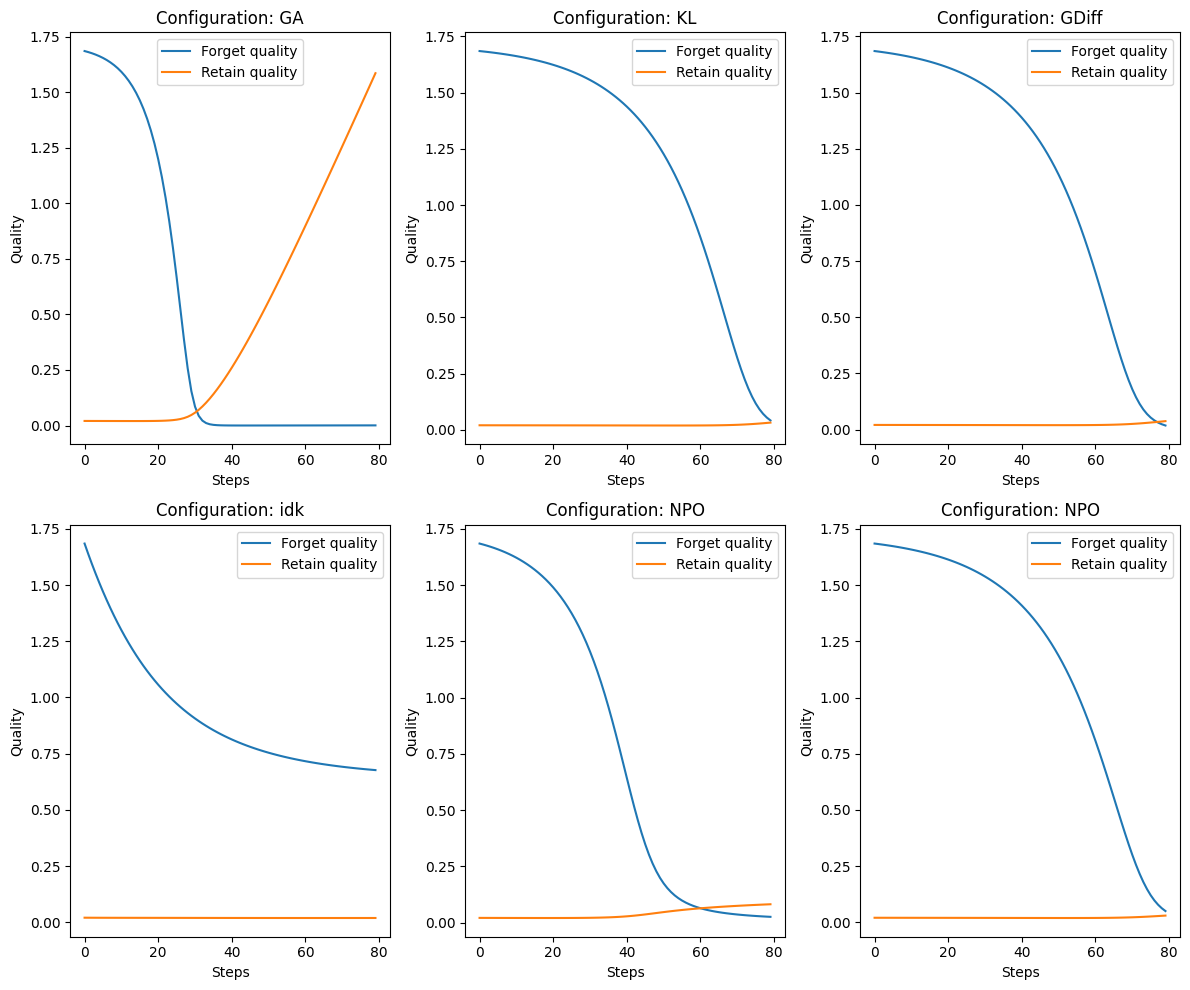

In [71]:
import pickle
import matplotlib.pyplot as plt
import os

# Function to unpickle a file
def load_pickle(file_path):
    with open(file_path, 'rb') as file:
        return pickle.load(file)

# Define paths to the relevant pickle files
pickle_directory = 'record/record_d16_N128_K_2_nf200_nr_1000_alpha_1'
run_id = 1
seed = 1000  # Example seed
pickle_file = f'{pickle_directory}/record_seed_{seed}_{run_id}.pkl'

# Load the saved data
records, params_dict, models = load_pickle(pickle_file)

# Extract relevant data for plotting
# Assuming 'records' contains forget and retain distances per step
configurations = list(records.keys())

# Example plot generation based on configurations
fig, axes = plt.subplots(2, 3, figsize=(12, 10))

# Plotting each relevant metric
for idx, (record_key, ax) in enumerate(zip(records.keys(), axes.flatten())):
    data = records[record_key][0] 
    # print(record_key) # Example: Accessing the first set of recorded data
    steps = list(range(len(data['forget_quality'])))  # Assuming step-wise recording
    
    ax.plot(steps, data['forget_quality'], label="Forget quality")
    ax.plot(steps, data['retain_quality'], label="Retain quality")
    
    ax.set_title(f"Configuration: {record_key.split('_')[1]}")
    ax.set_xlabel("Steps")
    ax.set_ylabel("Quality")
    ax.legend()

plt.tight_layout()
plt.savefig("pic7.png")
plt.show()

[np.float64(1.9280681831744),
 np.float64(1.9187617495927909),
 np.float64(1.9093463389030785),
 np.float64(1.8998193686197553),
 np.float64(1.8901781633577766),
 np.float64(1.8804199503226053),
 np.float64(1.8705418545232118),
 np.float64(1.8605408936873473),
 np.float64(1.8504139728566056),
 np.float64(1.8401578786367436),
 np.float64(1.8297692730765558),
 np.float64(1.8192446871461103),
 np.float64(1.808580513782475),
 np.float64(1.7977730004680441),
 np.float64(1.7868182413032556),
 np.float64(1.7757121685317954),
 np.float64(1.7644505434722686),
 np.float64(1.7530289468057556),
 np.float64(1.74144276816355),
 np.float64(1.72968719495369),
 np.float64(1.7177572003585078),
 np.float64(1.7056475304282825),
 np.float64(1.693352690188058),
 np.float64(1.680866928665672),
 np.float64(1.6681842227388888),
 np.float64(1.6552982596880708),
 np.float64(1.6422024183278792),
 np.float64(1.628889748576822),
 np.float64(1.6153529493068326),
 np.float64(1.6015843442961424),
 np.float64(1.5875758

[np.float64(0.8492501682057038),
 np.float64(0.8451509924848719),
 np.float64(0.8410038159577437),
 np.float64(0.8368075011249961),
 np.float64(0.8325608695681388),
 np.float64(0.8282626999630257),
 np.float64(0.8239117259713407),
 np.float64(0.8195066340009454),
 np.float64(0.8150460608251803),
 np.float64(0.8105285910503248),
 np.float64(0.8059527544194405),
 np.float64(0.8013170229397526),
 np.float64(0.796619807819522),
 np.float64(0.7918594561990442),
 np.float64(0.7870342476589436),
 np.float64(0.7821423904873062),
 np.float64(0.7771820176853826),
 np.float64(0.7721511826895766),
 np.float64(0.7670478547851898),
 np.float64(0.761869914184878),
 np.float64(0.7566151467419701),
 np.float64(0.7512812382656487),
 np.float64(0.7458657684014648),
 np.float64(0.7403662040366793),
 np.float64(0.7347798921854609),
 np.float64(0.7291040523039156),
 np.float64(0.7233357679792262),
 np.float64(0.7174719779307133),
 np.float64(0.7115094662533109),
 np.float64(0.7054448518256017),
 np.float64(

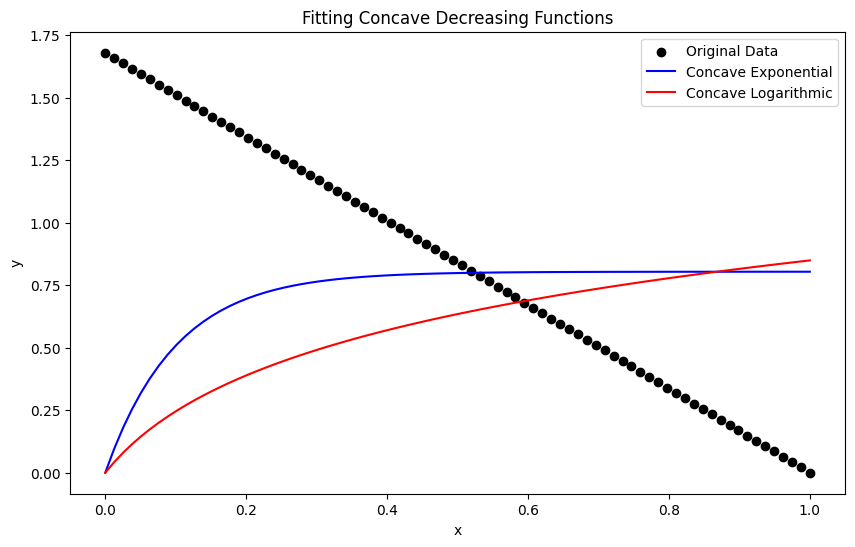

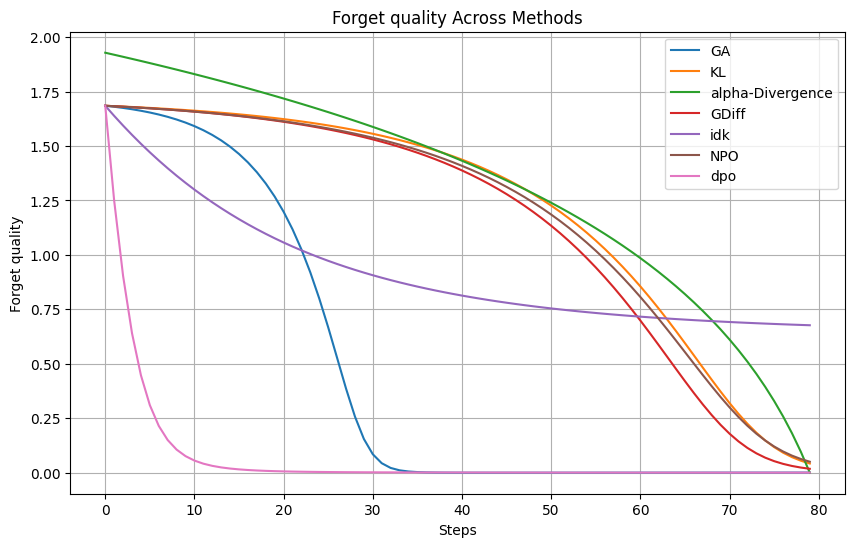

In [66]:
import pickle
import matplotlib.pyplot as plt
import os

# Function to unpickle a file
def load_pickle(file_path):
    with open(file_path, 'rb') as file:
        return pickle.load(file)

# Define paths to the relevant pickle files
pickle_directory = 'record/record_d16_N128_K_2_nf200_nr_1000_alpha_1'
run_id = 1
seed = 1000  # Example seed
pickle_file = f'{pickle_directory}/record_seed_{seed}_{run_id}.pkl'

# Load the saved data
# records, params_dict, models = load_pickle(pickle_file)

# Initialize dictionaries to store forget and retain distances
forget_distances = {}
retain_distances = {}
steps = None

# Extract forget and retain distances from the records
for record_key in records.keys():
    method = record_key.split('_')[1]  # Extract method name
    record_data = records[record_key][0]  # Assuming single record set per method
    if steps is None:
        steps = list(range(len(record_data['forget_quality'])))  # Get the number of steps
    forget_distances[method] = record_data['forget_quality']
    retain_distances[method] = record_data['retain_quality']

# Plot Forget Distance
plt.figure(figsize=(10, 6))
for method, distances in forget_distances.items():
    plt.plot(steps, distances, label=method)
plt.title("Forget quality Across Methods")
plt.xlabel("Steps")
plt.ylabel("Forget quality")
plt.legend()
plt.grid()
plt.savefig("pic5.png")
plt.show()

# # Plot Retain Distance
# plt.figure(figsize=(10, 6))
# for method, distances in retain_distances.items():
#     plt.plot(steps, distances, label=method)
# plt.title("Retain quality Across Methods")
# plt.xlabel("Steps")
# plt.ylabel("Retain Quality")
# plt.legend()
# plt.grid()
# plt.savefig("pic4.png")
# plt.show()

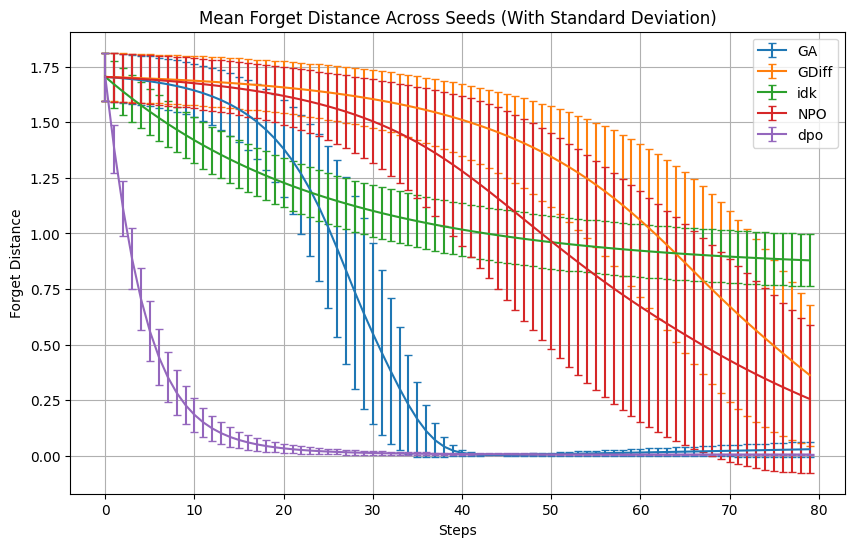

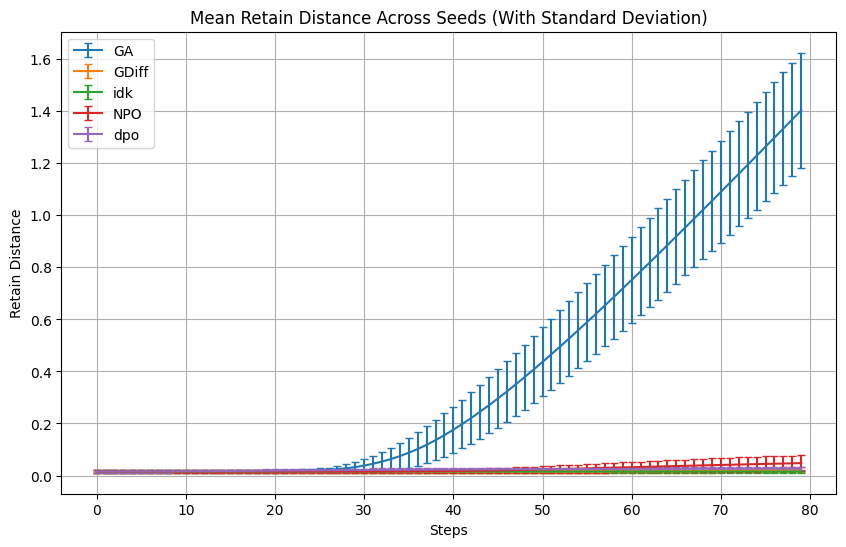

In [24]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import os

# Function to unpickle a file
def load_pickle(file_path):
    with open(file_path, 'rb') as file:
        return pickle.load(file)

# Define paths to the relevant pickle files
pickle_directory = 'record/record_d16_N128_K_2_nf200_nr_1000_alpha_1'
run_id = 1
seed_list = [1000, 2000, 3000, 4000, 5000]  # List of seeds

# Initialize storage for distances
forget_distances = {}
retain_distances = {}
methods = None

# Loop over each seed and load data
for seed in seed_list:
    pickle_file = f'{pickle_directory}/record_seed_{seed}_{run_id}.pkl'
    records, _, _ = load_pickle(pickle_file)

    if methods is None:
        methods = list(records.keys())

    for method_key in methods:
        method = method_key.split('_')[1]  # Extract method name

        # Extract distances for each method
        record_data = records[method_key][0]  # Assuming single record set per method
        steps = list(range(len(record_data['forget_quality'])))

        # Initialize storage if not already done
        if method not in forget_distances:
            forget_distances[method] = []
            retain_distances[method] = []

        forget_distances[method].append(record_data['forget_quality'])
        retain_distances[method].append(record_data['retain_quality'])

# Calculate mean and std across seeds
mean_forget = {}
std_forget = {}
mean_retain = {}
std_retain = {}

for method in forget_distances.keys():
    forget_array = np.array(forget_distances[method])  # Shape: (num_seeds, num_steps)
    retain_array = np.array(retain_distances[method])

    mean_forget[method] = np.mean(forget_array, axis=0)
    std_forget[method] = np.std(forget_array, axis=0)

    mean_retain[method] = np.mean(retain_array, axis=0)
    std_retain[method] = np.std(retain_array, axis=0)

# Plot Forget Distance with error bars
plt.figure(figsize=(10, 6))
for method in mean_forget.keys():
    plt.errorbar(steps, mean_forget[method], yerr=std_forget[method], label=method, capsize=3)
plt.title("Mean Forget Distance Across Seeds (With Standard Deviation)")
plt.xlabel("Steps")
plt.ylabel("Forget Distance")
plt.legend()
plt.grid()
plt.show()

# Plot Retain Distance with error bars
plt.figure(figsize=(10, 6))
for method in mean_retain.keys():
    plt.errorbar(steps, mean_retain[method], yerr=std_retain[method], label=method, capsize=3)
plt.title("Mean Retain Distance Across Seeds (With Standard Deviation)")
plt.xlabel("Steps")
plt.ylabel("Retain Distance")
plt.legend()
plt.grid()
plt.show()